# Library Instillation

1. **Run the code below to get the proper libraries that are needed.**

In [ ]:
!pip install openpyxl matplotlib seaborn ipywidgets
!pip install -U kaleido
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyterlab-plotly
!jupyter nbextension enable --py widgetsnbextension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 1.9 MB/s eta 0:00:00
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension console dejavu events exe

# Selected 10 Players
This code take ten pre-selected players and tries matching, using RandomForest, XGBoosting, and Logistcal Regression

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Import ipywidgets for interactive dashboard
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Configuration Section (Managed by ipywidgets Dashboard) ---

# Define the list of players for analysis (fixed)
player_name_list = [
    'Josko Gvardiol', 'Virgil van Dijk', 'William Saliba', 'Trent Alexander-Arnold',
    'Declan Rice', 'Ryan Gravenberch', 'Matheus Cunha', 'Bryan Mbeumo',
    'Alexander Isak', 'Mohamed Salah'
]

# Define all possible features, categorized for the dashboard
FEATURE_CATEGORIES = {
    "General Metrics": [
        'Games Played', 'Games Started', 'Minutes Played'
    ],
    "Offensive & Shooting": [
        'Goals', 'Assists', 'Goals (left-footed)', 'Goals (right-footed)', 'Goals (headed)',
        'Goals (outside box)', 'Goals (inside box)', 'Total Shots (inc. Blocks)',
        'Total Shots (ex. Blocks)', 'Shots on Target', 'Shots off Target',
        'Blocked Shots', 'Total Shots Inside Box (inc. Blocks)',
        'Total Shots Outside Box (inc. Blocks)', 'Direct Free Kick Shots (inc. Blocks)',
        'Expected Goals on Target', 'Expected Assists', 'Expected Goals', 'Offsides'
    ],
    "Carrying & Dribbling": [
        'successfulTakeOn', 'totalTakeOn', 'Total Carries', 'Total Carry Distance',
        'Average Carry Distance'
    ],
    "Passing": [
        'Passes, ending in Final 1/3', 'Successful Passes, ending in Final 1/3',
        'Passes', 'Passes Successful', 'Passes Own Half', 'Corners'
    ],
    "Defensive & Tackling": [
        'Goals Conceded', 'Clean Sheets *', 'Own Goals', 'Tackles', 'Tackles Won',
        'Tackles Lost', 'Clearances (inc. Punches)', 'Interceptions', 'Headed Clearances',
        'Cross Blocked', 'Possession Won', 'Blocks', 'Fouls Conceded', 'Fouls Won',
        'Penalties Conceded', 'Penalties Won', 'Duels', 'Duels Won', 'Duels Lost',
        'Recoveries'
    ],
    "Discipline": [
        'Yellow Cards'
    ]
}

# Flatten all features into a single list for initial validation/processing
ALL_FLATTENED_FEATURES = [feature for category_list in FEATURE_CATEGORIES.values() for feature in category_list]


# --- 1. Data Loading (REVISED FOR GITHUB REPOSITORY) ---
GITHUB_RAW_URL = "https://raw.githubusercontent.com/stjamessoto/Sloan-Data-Repository/main/player_per_game.xlsx"

def load_data():
    """Loads the player data directly from the GitHub repository's raw file URL."""
    print(f"Loading data from GitHub: {GITHUB_RAW_URL}...")
    try:
        # pandas can read Excel files directly from a URL.
        player_df = pd.read_excel(GITHUB_RAW_URL, engine='openpyxl')
        print("Data loaded successfully.")
        return player_df.copy()
    except Exception as e:
        print(f"Error loading data from GitHub URL: {e}")
        print("Please ensure the GITHUB_RAW_URL variable is set to the correct raw file link.")
        return None

# Load data once when the script runs
df = load_data()
if df is None:
    print("Failed to load data. Exiting.")
    # Exit here to prevent dashboard execution with no data
    # (Comment out `exit()` if running in a non-terminating notebook environment)
    # exit()

# --- 2. Preprocessing and Data Splitting Function ---
def preprocess_and_split_data(raw_df, selected_features, player_list):
    """
    Preprocesses the data and splits it into training and testing sets
    based on selected features and player list.
    """
    if 'Player Name' not in raw_df.columns:
        print("Error: 'Player Name' column not found in the data. This column is required as the target variable.")
        return None, None, None, None, None, None, None

    if player_list:
        filtered_df = raw_df[raw_df["Player Name"].isin(player_list)].copy()
        if filtered_df.empty:
            print(f"Error: No data found for the specified players: {player_list}.")
            return None, None, None, None, None, None, None
    else:
        filtered_df = raw_df.copy()

    actual_features_to_use = []
    for col in selected_features:
        if col in filtered_df.columns:
            filtered_df[col] = pd.to_numeric(filtered_df[col], errors='coerce')
            actual_features_to_use.append(col)
        else:
            print(f"Warning: Selected feature '{col}' not found in the dataset. It will be skipped.")

    if not actual_features_to_use:
        print("Error: No valid features selected or found in the dataset. Cannot proceed.")
        return None, None, None, None, None, None, None

    cols_to_keep = actual_features_to_use + ['Player Name']
    filtered_df = filtered_df[[col for col in cols_to_keep if col in filtered_df.columns]].copy()
    filtered_df = filtered_df.fillna(0)

    if filtered_df.empty:
        print("Error: No valid data remaining after feature selection and NaN handling. Cannot proceed.")
        return None, None, None, None, None, None, None

    train_list, test_list = [], []
    unique_players_in_filtered_df = filtered_df["Player Name"].unique()

    label_encoder = LabelEncoder()
    label_encoder.fit(filtered_df['Player Name'])
    target_classes = label_encoder.classes_

    if len(unique_players_in_filtered_df) < 2:
        print(f"Warning: Only {len(unique_players_in_filtered_df)} unique player(s) found after filtering. Cannot perform stratified split by player.")
        X = filtered_df[actual_features_to_use]
        y = filtered_df['Player Name']
        y_encoded = label_encoder.transform(y)
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded if len(np.unique(y_encoded)) > 1 else None)
    else:
        for player_name in unique_players_in_filtered_df:
            player_games = filtered_df[filtered_df["Player Name"] == player_name].copy()
            if len(player_games) < 2:
                print(f"Warning: Player '{player_name}' has only {len(player_games)} game(s). Adding to training set without splitting.")
                train_list.append(player_games)
            else:
                player_games['Player Name Encoded'] = label_encoder.transform(player_games['Player Name'])
                train_data, test_data = train_test_split(
                    player_games,
                    test_size=0.3,
                    random_state=42,
                    stratify=player_games['Player Name Encoded']
                )
                train_list.append(train_data)
                test_list.append(test_data)

        if not train_list or not test_list:
            print("Error: No data available for training or testing after per-player splitting. Check 'player_name_list' or data content.")
            return None, None, None, None, None, None, None

        train_df = pd.concat(train_list)
        test_df = pd.concat(test_list)

        X_train = train_df[actual_features_to_use]
        y_train = train_df['Player Name Encoded'] if 'Player Name Encoded' in train_df.columns else label_encoder.transform(train_df['Player Name'])

        X_test = test_df[actual_features_to_use]
        y_test = test_df['Player Name Encoded'] if 'Player Name Encoded' in test_df.columns else label_encoder.transform(test_df['Player Name'])


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, target_classes, X_train_scaled, X_test_scaled

# --- 3. Model Training and Evaluation Function ---
def evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, model_name, class_labels):
    """
    Trains a model, makes predictions, calculates accuracy, and plots the confusion matrix.
    """
    model.fit(X_train_data, y_train_data)
    y_pred = model.predict(X_test_data)
    accuracy = accuracy_score(y_test_data, y_pred)

    print(f"\n--- Results for {model_name} ---")
    print(f"Overall accuracy: {accuracy:.2%}")

    cm = confusion_matrix(y_test_data, y_pred, labels=np.arange(len(class_labels)))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=[str(c) for c in class_labels],
                yticklabels=[str(c) for c in class_labels],
                cmap="Blues")

    plt.xlabel(f"Predicted Player Name ({model_name})")
    plt.ylabel("Actual Player Name")
    plt.title(f"Confusion Matrix of Player Identification by Name ({model_name})")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# --- ipywidgets Dashboard Setup ---

if df is not None:
    # Model Selection Widget
    model_selector = widgets.RadioButtons(
        options=['Logistic Regression', 'Random Forest', 'XGBoost'],
        value='Random Forest',
        description='Select Model:',
        disabled=False,
        layout=widgets.Layout(width='auto', flex='1 1 auto')
    )

    # Feature Selection Widgets (Categorized Checkboxes)
    feature_checkboxes = {}
    accordion_children = []
    for category, features in FEATURE_CATEGORIES.items():
        category_checkboxes = []
        for feature in features:
            if feature in df.columns:
                checkbox = widgets.Checkbox(
                    value=True,
                    description=feature,
                    disabled=False
                )
                feature_checkboxes[feature] = checkbox
                category_checkboxes.append(checkbox)

        if category_checkboxes:
            accordion_children.append(widgets.VBox(category_checkboxes))

    feature_accordion = widgets.Accordion(children=accordion_children)
    for i, category in enumerate(FEATURE_CATEGORIES.keys()):
        feature_accordion.set_title(i, category)


    # Run Button
    run_button = widgets.Button(
        description='Run Analysis',
        button_style='success',
        tooltip='Click to run the selected model with chosen features',
        icon='play'
    )

    # Output area for results
    output_area = widgets.Output()

    # Function to handle button click
    def on_run_button_clicked(b):
        with output_area:
            clear_output(wait=True)
            print("Running analysis...")

            selected_model_name = model_selector.value
            selected_features = [feature for feature, checkbox in feature_checkboxes.items() if checkbox.value]

            if not selected_features:
                print("Error: No features selected. Please select at least one feature to run the analysis.")
                return

            X_train, X_test, y_train, y_test, target_classes, X_train_scaled, X_test_scaled = \
                preprocess_and_split_data(df, selected_features, player_name_list)

            if X_train is None:
                print("Analysis aborted due to data issues during preprocessing.")
                return

            if selected_model_name == 'Logistic Regression':
                model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
                X_train_for_model = X_train_scaled
                X_test_for_model = X_test_scaled
            elif selected_model_name == 'Random Forest':
                model = RandomForestClassifier(n_estimators=100, random_state=42)
                X_train_for_model = X_train
                X_test_for_model = X_test
            elif selected_model_name == 'XGBoost':
                model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
                X_train_for_model = X_train
                X_test_for_model = X_test
            else:
                print(f"Error: Invalid model selected '{selected_model_name}'.")
                return

            evaluate_model(model, X_train_for_model, y_train, X_test_for_model, y_test, selected_model_name, target_classes)
            print("\nAnalysis complete!")

    # Attach the event handler to the button
    run_button.on_click(on_run_button_clicked)

    # Display the dashboard widgets
    dashboard_layout = widgets.VBox([
        widgets.HTML("<h2>Player Identification Model Dashboard</h2>"),
        model_selector,
        widgets.HTML("<h3>Select Features:</h3>"),
        feature_accordion,
        run_button,
        output_area
    ])

    display(dashboard_layout)
else:
    print("Dashboard cannot be displayed because data loading failed.")

Loading data from GitHub: https://raw.githubusercontent.com/stjamessoto/Sloan-Data-Repository/main/player_per_game.xlsx...
Data loaded successfully.


# Player Consistency
This code helps with seeing how consistent players are on a game to game basis.

Download and load complete.
Data loaded successfully for PCA analysis.
Original DataFrame deleted and garbage collected.

Training internal RandomForest model for predictive embeddings (using RandomizedSearchCV for speed)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for internal RandomForest model: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 459}
Best cross-validation accuracy for internal model: 0.61
Internal RandomForest model (tuned) trained successfully for predictive embeddings.

Generating predictive embeddings for all players...
Players assigned to 10 clusters based on highest predictive probability.
Performing PCA on predictive embeddings...
PCA on embeddings performed. Explained variance by PC1: 0.47, PC2: 0.20

Preparing sampled game instances for highlighted players for plotting...
Prepared 50 sampled game instances for 10 players for highlighting.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


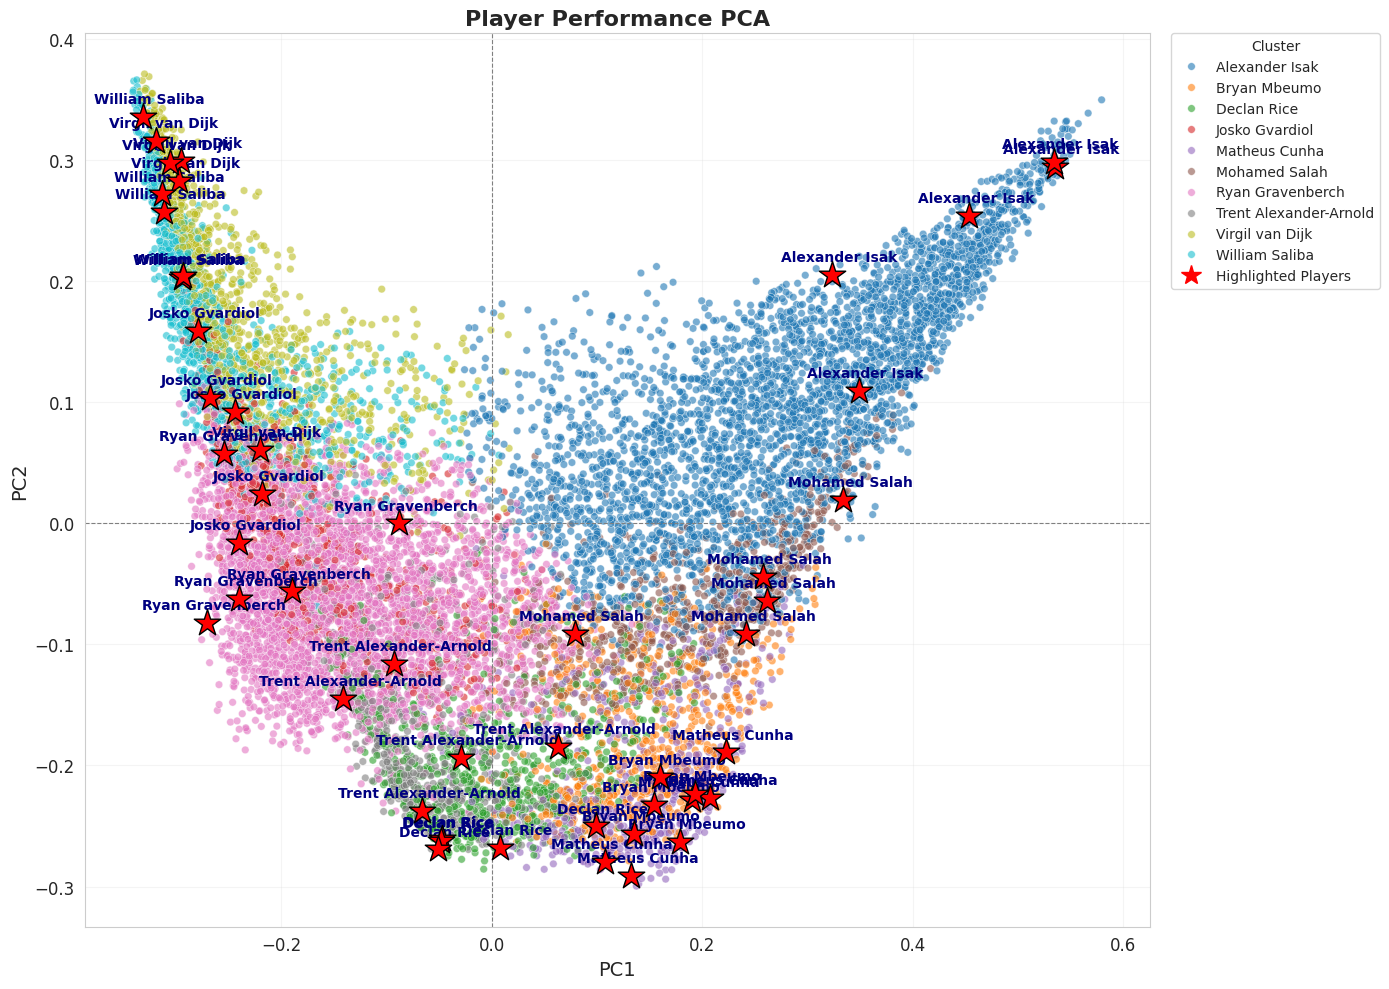


PCA graph with predictive embeddings and improved clustering generated successfully.


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
# KMeans is no longer used for primary clustering, but kept for potential future use or if a different clustering is desired.
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV # Changed from GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import randint # For RandomizedSearchCV parameter distributions
import gc # Import garbage collector for explicit memory management
import requests # NEW: Import requests for downloading data from a URL

# --- Configuration ---

# Define the list of 10 players to be highlighted on the graph
highlighted_player_names = [
    'Josko Gvardiol', 'Virgil van Dijk', 'William Saliba', 'Trent Alexander-Arnold',
    'Declan Rice', 'Ryan Gravenberch', 'Matheus Cunha', 'Bryan Mbeumo',
    'Alexander Isak', 'Mohamed Salah'
]

# Define all features to be used for PCA (these will first be used by the classification model)
ALL_FEATURES_FOR_PCA = [
    'Goals', 'Assists', 'Games Played', 'Games Started', 'Minutes Played',
    'successfulTakeOn', 'totalTakeOn', 'Total Carries', 'Total Carry Distance',
    'Average Carry Distance', 'Passes, ending in Final 1/3', 'Successful Passes, ending in Final 1/3',
    'Passes', 'Passes Successful', 'Passes Own Half', 'Corners',
    'Goals (left-footed)', 'Goals (right-footed)', 'Goals (headed)',
    'Goals (outside box)', 'Goals (inside box)',
    'Total Shots (inc. Blocks)', 'Total Shots (ex. Blocks)', 'Shots on Target',
    'Shots off Target', 'Blocked Shots', 'Total Shots Inside Box (inc. Blocks)',
    'Total Shots Outside Box (inc. Blocks)', 'Direct Free Kick Shots (inc. Blocks)',
    'Expected Goals on Target', 'Expected Assists', 'Expected Goals', 'Goals Conceded',
    'Clean Sheets *', 'Own Goals', 'Tackles', 'Tackles Won', 'Tackles Lost',
    'Clearances (inc. Punches)', 'Interceptions', 'Headed Clearances',
    'Cross Blocked', 'Possession Won', 'Blocks', 'Fouls Conceded', 'Fouls Won',
    'Penalties Conceded', 'Penalties Won', 'Duels', 'Duels Won', 'Duels Lost',
    'Recoveries'
]

# --- 1. Data Loading ---
github_raw_url = "https://raw.githubusercontent.com/stjamessoto/Sloan-Data-Repository/main/player_per_game.xlsx"

def load_data_from_github(url):
    """Loads the player data from a GitHub raw Excel file URL."""
    print(f"Downloading data from GitHub URL: {url}...")
    try:
        # Use requests to get the raw content
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

        # Read the Excel file directly into pandas from the response content
        # The io.BytesIO method is ideal for reading from a URL response
        from io import BytesIO
        player_df = pd.read_excel(BytesIO(response.content), engine='openpyxl')

        print("Download and load complete.")
        return player_df.copy()

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file from GitHub: {e}")
        print("Please ensure the URL is the correct 'raw' content link and the file exists.")
        return None
    except Exception as e:
        print(f"Error loading Excel file with openpyxl engine: {e}")
        print("Please ensure 'openpyxl' is installed (pip install openpyxl).")
        return None

# Load the full dataset
# The file_name and dropbox_url variables from the original code are no longer needed
df = load_data_from_github(github_raw_url)
if df is None:
    print("Failed to load data. Exiting PCA graph generation.")
    exit()

print("Data loaded successfully for PCA analysis.")

# --- 2. Data Preprocessing for Internal Classification Model and PCA ---

# Select only the features relevant for the classification model and subsequent PCA
features_for_model_and_pca = [f for f in ALL_FEATURES_FOR_PCA if f in df.columns]
if not features_for_model_and_pca:
    print("Error: No valid features found in the dataset for model training or PCA. Cannot proceed.")
    exit()

# Crucial for RAM: Select only necessary columns early
# Also include 'Player Name' for later use
required_cols = features_for_model_and_pca + ['Player Name']
df_processed = df[required_cols].copy()

# Convert features to numeric, coercing errors, and downcast for memory efficiency
for col in features_for_model_and_pca: # Only apply to feature columns
    # Convert to numeric, errors='coerce' turns non-convertible values into NaN
    df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    # Attempt to downcast to smaller float type if possible
    df_processed[col] = df_processed[col].astype(np.float32) # Use float32 for less memory

df_processed = df_processed.fillna(0) # Fill NaNs after conversion and downcasting

if df_processed[features_for_model_and_pca].empty:
    print("Error: No valid data remaining after feature selection and NaN handling for PCA. Cannot proceed.")
    exit()

# Explicitly delete original df to free memory
del df
gc.collect()
print("Original DataFrame deleted and garbage collected.")


# --- 3. Train an Internal Classification Model for Predictive Embeddings ---
print("\nTraining internal RandomForest model for predictive embeddings (using RandomizedSearchCV for speed)...")

# Filter data for the 10 highlighted players to train the model
highlighted_players_data = df_processed[df_processed['Player Name'].isin(highlighted_player_names)].copy()

if highlighted_players_data.empty:
    print(f"Error: No data found for the highlighted players: {highlighted_player_names}. Cannot train internal model.")
    exit()

X_train_model = highlighted_players_data[features_for_model_and_pca]
y_train_model_names = highlighted_players_data['Player Name']

# Encode player names to numerical labels for model training
label_encoder_model = LabelEncoder()
y_train_model_encoded = label_encoder_model.fit_transform(y_train_model_names)
# Store the class names (player names) for later use in probabilities
model_target_classes = label_encoder_model.classes_

# Ensure all 10 highlighted players are present as classes for the model
if len(model_target_classes) != len(highlighted_player_names):
    print(f"Warning: Only {len(model_target_classes)} out of {len(highlighted_player_names)} highlighted players have data for training the internal model.")
    print("Clusters will be based on available highlighted players.")

# Scale features for the internal model
scaler_model = StandardScaler()
X_train_model_scaled = scaler_model.fit_transform(X_train_model)

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 500), # Random integer from 100 to 500
    'max_features': ['sqrt', 'log2', None],
    'max_depth': randint(10, 50), # Random integer for max_depth
    'min_samples_leaf': randint(1, 5),
    'class_weight': ['balanced', None]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=50, # Number of parameter settings that are sampled. Adjust for speed vs. thoroughness.
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit RandomizedSearchCV to find the best model
random_search.fit(X_train_model_scaled, y_train_model_encoded)

internal_classifier_model = random_search.best_estimator_
print(f"Best parameters for internal RandomForest model: {random_search.best_params_}")
print(f"Best cross-validation accuracy for internal model: {random_search.best_score_:.2f}")
print("Internal RandomForest model (tuned) trained successfully for predictive embeddings.")

# --- 4. Generate Predictive Embeddings for All Players ---
print("\nGenerating predictive embeddings for all players...")

X_all_players = df_processed[features_for_model_and_pca]
X_all_players_scaled = scaler_model.transform(X_all_players)

predictive_embeddings = internal_classifier_model.predict_proba(X_all_players_scaled)

# Create a DataFrame for these embeddings
embeddings_df = pd.DataFrame(predictive_embeddings, columns=[f'Prob_{name}' for name in model_target_classes])

# --- NEW: Assign players to clusters based on highest probability ---
# The cluster name will be the name of the highlighted player they are most similar to
pca_df_embeddings = pd.DataFrame() # Initialize an empty DataFrame
pca_df_embeddings['Player Name'] = df_processed['Player Name'].reset_index(drop=True)
pca_df_embeddings['Cluster'] = embeddings_df.idxmax(axis=1).apply(lambda x: x.replace('Prob_', ''))
print(f"Players assigned to {len(model_target_classes)} clusters based on highest predictive probability.")


# --- 5. Perform PCA on Predictive Embeddings ---
print("Performing PCA on predictive embeddings...")

pca = PCA(n_components=2)
principal_components_from_embeddings = pca.fit_transform(embeddings_df) # PCA on the probabilities

# Add PCA components to the pca_df_embeddings DataFrame
pca_df_embeddings['PC1'] = principal_components_from_embeddings[:, 0]
pca_df_embeddings['PC2'] = principal_components_from_embeddings[:, 1]


print(f"PCA on embeddings performed. Explained variance by PC1: {pca.explained_variance_ratio_[0]:.2f}, PC2: {pca.explained_variance_ratio_[1]:.2f}")


# --- 6. Prepare Sampled Games for Highlighted Players for Plotting ---
print("\nPreparing sampled game instances for highlighted players for plotting...")

sampled_highlighted_games_list = []
num_samples_per_player = 5 # Number of games to sample for each highlighted player

for player_name in highlighted_player_names:
    player_games = df_processed[df_processed['Player Name'] == player_name].copy()
    if not player_games.empty:
        if len(player_games) > num_samples_per_player:
            # Sample N games if available
            sampled_games = player_games.sample(n=num_samples_per_player, random_state=42)
            sampled_highlighted_games_list.append(sampled_games)
        else:
            # Use all games if less than N
            sampled_highlighted_games_list.append(player_games)
            print(f"Note: Player '{player_name}' has only {len(player_games)} games, using all for highlighting.")
    else:
        print(f"Warning: No game data found for '{player_name}'. Skipping for highlighting.")

if not sampled_highlighted_games_list:
    print("No game instances found for any highlighted player. No stars will be plotted.")
    highlighted_players_pca = pd.DataFrame()
else:
    df_sampled_highlighted_games = pd.concat(sampled_highlighted_games_list)

    X_sampled_highlighted_games = df_sampled_highlighted_games[features_for_model_and_pca].copy()
    X_sampled_highlighted_games_scaled = scaler_model.transform(X_sampled_highlighted_games)
    sampled_highlighted_games_embeddings = internal_classifier_model.predict_proba(X_sampled_highlighted_games_scaled)

    # Transform these embeddings using the SAME PCA fitted on ALL embeddings
    highlighted_players_pca_coords = pca.transform(sampled_highlighted_games_embeddings)

    highlighted_players_pca = pd.DataFrame(
        data=highlighted_players_pca_coords,
        columns=['PC1', 'PC2']
    )
    highlighted_players_pca['Player Name'] = df_sampled_highlighted_games['Player Name'].reset_index(drop=True)

    print(f"Prepared {len(highlighted_players_pca)} sampled game instances for {len(highlighted_player_names)} players for highlighting.")


# --- 7. Generate PCA Graph ---

plt.figure(figsize=(14, 10))
plt.rcParams['axes.facecolor'] = '#e6efff'
sns.set_style("whitegrid")

# Define a consistent color palette for the 10 clusters (player names)
cluster_palette = sns.color_palette("tab10", n_colors=len(model_target_classes))
if len(model_target_classes) > 10:
    cluster_palette = sns.color_palette("husl", n_colors=len(model_target_classes))

cluster_color_map = {name: cluster_palette[i] for i, name in enumerate(model_target_classes)}


scatterplot = sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster', # Hue is now the player name they are most similar to
    palette=cluster_color_map, # Use the consistent color map
    data=pca_df_embeddings,
    s=30,
    alpha=0.6,
    legend='full'
)

if not highlighted_players_pca.empty:
    # Plot highlighted players' sampled game instances as red stars
    plt.scatter(
        highlighted_players_pca['PC1'],
        highlighted_players_pca['PC2'],
        marker='*',
        s=400,
        color='red',
        edgecolors='black',
        linewidth=1,
        label='Highlighted Players',
        zorder=5
    )

    # Annotate highlighted players with their names (will annotate each point, may cause overlap)
    # For a cleaner look with many points, you might annotate only the player name once (e.g., at the centroid of their points).
    # For now, we annotate each.
    for i, row in highlighted_players_pca.iterrows():
        plt.annotate(
            row['Player Name'],
            (row['PC1'], row['PC2']),
            textcoords="offset points",
            xytext=(5, 10),
            ha='center',
            fontsize=10,
            fontweight='bold',
            color='navy'
        )
else:
    print("No game instances to highlight for the specified players.")


# Customize plot aesthetics
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.title("Player Performance PCA", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='-', alpha=0.2)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust legend to include 'Highlighted Players'
handles, labels = scatterplot.get_legend_handles_labels()

# Reorder handles and labels to match the desired legend order (clusters first, then highlighted)
sorted_cluster_labels = sorted([label for label in labels if label != 'Highlighted Players'])
sorted_handles = [handles[labels.index(lbl)] for lbl in sorted_cluster_labels]

star_proxy = plt.Line2D([0], [0], marker='*', color='red', markersize=15, linestyle='None', label='Highlighted Players')

sorted_handles.append(star_proxy)
sorted_cluster_labels.append('Highlighted Players')

# Place legend outside the plot
plt.legend(handles=sorted_handles, labels=sorted_cluster_labels, title="Cluster", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

print("\nPCA graph with predictive embeddings and improved clustering generated successfully.")

# Use Cases
These are sample use cases for the code.

In [5]:
# Use Cases
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

# --- Configuration for Similarity Analysis ---

# Define the list of 10 target players for analysis (fixed)
# These are the players whose "archetype" we will compare others against.
player_name_list = [
    'Josko Gvardiol', 'Virgil van Dijk', 'William Saliba', 'Trent Alexander-Arnold',
    'Declan Rice', 'Ryan Gravenberch', 'Matheus Cunha', 'Bryan Mbeumo',
    'Alexander Isak', 'Mohamed Salah'
]

# Minimum number of games a player must have played to be considered for similarity analysis
MIN_GAMES_FOR_ELIGIBILITY = 10

# Define all possible features for the model (same as the main dashboard)
# These features will be used to train the internal model for similarity scoring
ALL_FEATURES_FOR_SIMILARITY = [
    'Goals', 'Assists', 'Games Played', 'Games Started', 'Minutes Played',
    'successfulTakeOn', 'totalTakeOn', 'Total Carries', 'Total Carry Distance',
    'Average Carry Distance', 'Passes, ending in Final 1/3', 'Successful Passes, ending in Final 1/3',
    'Passes', 'Passes Successful', 'Passes Own Half', 'Corners',
    'Goals (left-footed)', 'Goals (right-footed)', 'Goals (headed)',
    'Goals (outside box)', 'Goals (inside box)',
    'Total Shots (inc. Blocks)', 'Total Shots (ex. Blocks)', 'Shots on Target',
    'Shots off Target', 'Blocked Shots', 'Total Shots Inside Box (inc. Blocks)',
    'Total Shots Outside Box (inc. Blocks)', 'Direct Free Kick Shots (inc. Blocks)',
    'Expected Goals on Target', 'Expected Assists', 'Expected Goals', 'Goals Conceded',
    'Clean Sheets *', 'Own Goals', 'Tackles', 'Tackles Won', 'Tackles Lost',
    'Clearances (inc. Punches)', 'Interceptions', 'Headed Clearances',
    'Cross Blocked', 'Possession Won', 'Blocks', 'Fouls Conceded', 'Fouls Won',
    'Penalties Conceded', 'Penalties Won', 'Duels', 'Duels Won', 'Duels Lost',
    'Recoveries'
]

# --- 1. Data Loading (MODIFIED SECTION) ---
github_raw_url = "https://raw.githubusercontent.com/stjamessoto/Sloan-Data-Repository/main/player_per_game.xlsx"

def load_data():
    """Loads the player data from the GitHub raw Excel file URL."""
    print(f"Loading data from GitHub URL: {github_raw_url}...")
    try:
        # pandas can read directly from a URL for many file types, including Excel
        player_df = pd.read_excel(github_raw_url)
        print("Download and load complete.")
        return player_df.copy()
    except Exception as e:
        print(f"Error loading data from GitHub URL: {github_raw_url}")
        print(f"Ensure the URL is a public 'raw' file link and accessible.")
        print(f"Details: {e}")
        return None

# Load the full dataset once
full_df = load_data()
if full_df is None:
    print("Failed to load data. Exiting similarity analysis.")
    exit()

print("Data loaded successfully for similarity analysis.")

# --- 2. Internal Model Training for Probability Generation ---
# This model will be trained on the 10 specific players to learn their "profiles"
# and then used to predict probabilities for other players.

print("\nTraining internal model for similarity scoring...")

# Filter data for the 10 target players
target_players_df = full_df[full_df["Player Name"].isin(player_name_list)].copy()

if target_players_df.empty:
    print(f"Error: No data found for the target players: {player_name_list}. Cannot train similarity model.")
    exit()

# Prepare features (X) and target (y) for the internal model
# Ensure only features present in the dataframe are used
actual_features_for_model = [f for f in ALL_FEATURES_FOR_SIMILARITY if f in target_players_df.columns]
if not actual_features_for_model:
    print("Error: No valid features found in the dataset for model training. Cannot proceed with similarity analysis.")
    exit()

X_model_train = target_players_df[actual_features_for_model].copy()
y_model_train_names = target_players_df['Player Name'].copy()

# Convert features to numeric, coercing errors, and fill NaNs
for col in X_model_train.columns:
    X_model_train[col] = pd.to_numeric(X_model_train[col], errors='coerce')
X_model_train = X_model_train.fillna(0)

# Encode player names to numerical labels
label_encoder_similarity = LabelEncoder()
y_model_train_encoded = label_encoder_similarity.fit_transform(y_model_train_names)
target_classes_similarity = label_encoder_similarity.classes_ # These are the 10 player names

# Scale features for the internal model (good practice)
scaler_similarity = StandardScaler()
X_model_train_scaled = scaler_similarity.fit_transform(X_model_train)

# Initialize and train the RandomForest model
# RandomForest is chosen here as a robust default for similarity scoring
similarity_model = RandomForestClassifier(n_estimators=100, random_state=42)
similarity_model.fit(X_model_train_scaled, y_model_train_encoded)

print("Internal similarity model trained.")

# --- 3. Filter and Aggregate Players for Similarity Comparison ---

print(f"\nFiltering players with at least {MIN_GAMES_FOR_ELIGIBILITY} games...")

# Step 1: Count the number of rows per player from the ORIGINAL full dataframe
player_counts_full_df = full_df['Player Name'].value_counts()

# Step 2: Filter players with at least MIN_GAMES_FOR_ELIGIBILITY rows
eligible_players_names = player_counts_full_df[player_counts_full_df >= MIN_GAMES_FOR_ELIGIBILITY].index
eligible_players_df = full_df[full_df['Player Name'].isin(eligible_players_names)].copy()

if eligible_players_df.empty:
    print(f"No players found with {MIN_GAMES_FOR_ELIGIBILITY} or more games. Cannot perform similarity analysis.")
    exit()
else:
    print(f"Found {len(eligible_players_names)} players with at least {MIN_GAMES_FOR_ELIGIBILITY} games.")

# Step 3: Group and aggregate numeric columns for eligible players
group_cols = ['Player Name']
# Use the same features as the model was trained on
numeric_cols_for_agg = [col for col in actual_features_for_model if col in eligible_players_df.columns]

# Ensure numeric conversion and fillna before aggregation
for col in numeric_cols_for_agg:
    eligible_players_df[col] = pd.to_numeric(eligible_players_df[col], errors='coerce')
eligible_players_df = eligible_players_df.fillna(0)

final_player_df_agg = eligible_players_df.groupby(group_cols)[numeric_cols_for_agg].mean().reset_index()

print(f"Aggregated data for {len(final_player_df_agg)} eligible players.")

# --- 4. Predict Probabilities for Aggregated Players ---

print("Predicting similarity probabilities...")

X_agg_for_prediction = final_player_df_agg[numeric_cols_for_agg]

# Apply the same scaler used during model training to the aggregated data
X_agg_for_prediction_scaled = scaler_similarity.transform(X_agg_for_prediction)

# Get probabilities for each class (the 10 target players)
probabilities = similarity_model.predict_proba(X_agg_for_prediction_scaled)

# Create probability columns (P(Player Name))
prob_df = pd.DataFrame(probabilities, columns=[f'P({player_name})' for player_name in target_classes_similarity])

# Combine aggregated features with probabilities
final_player_df_with_probs = pd.concat([final_player_df_agg, prob_df], axis=1)

# Ensure 'Player Name' is the first column for better display
if 'Player Name' in final_player_df_with_probs.columns:
    cols = ['Player Name'] + [col for col in final_player_df_with_probs.columns if col != 'Player Name']
    final_player_df_with_probs = final_player_df_with_probs[cols]

print("Similarity probabilities generated.")

# --- 5. ipywidgets for Similarity Display ---

print("\n--- Player Similarity Analysis Dashboard ---")

# Step 1: Get the list of archetype columns (P(Player Name) columns)
# These are the 10 players we are comparing against
archetype_cols = [f'P({player_name})' for player_name in player_name_list if f'P({player_name})' in final_player_df_with_probs.columns]

if not archetype_cols:
    print("No probability columns generated for the selected target players. Cannot display similarity dashboard.")
    # If no archetype columns, just display a message
    display(widgets.HTML("<h4>Similarity analysis not available. Ensure target players are in the data and the internal model trained successfully.</h4>"))
else:
    # Step 2: Create dropdown widget
    dropdown_similarity = widgets.Dropdown(
        options=archetype_cols,
        description='Compare to:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )

    # Output area for similarity results
    similarity_output_area = widgets.Output()

    # Step 3: Define callback to display top 10 similar players
    def show_top_similar(selected_col):
        with similarity_output_area:
            clear_output(wait=True)
            # Extract player name from 'P(Player Name)' format
            player_to_compare = selected_col.replace('P(', '').replace(')', '')
            print(f"Top 10 players most similar to '{player_to_compare}':")
            # Sort by the selected probability column in descending order
            sorted_df = final_player_df_with_probs.sort_values(by=selected_col, ascending=False)
            # Display Player Name and the selected probability column
            display(sorted_df[['Player Name', selected_col]].head(10))

    # Step 4: Create interaction
    widgets.interact(show_top_similar, selected_col=dropdown_similarity)

    # Display the similarity dashboard widgets
    display(widgets.VBox([
        widgets.HTML("<h3>Select a Target Player to find similar players:</h3>"),
        dropdown_similarity,
        similarity_output_area
    ]))

Loading data from GitHub URL: https://raw.githubusercontent.com/stjamessoto/Sloan-Data-Repository/main/player_per_game.xlsx...
Download and load complete.
Data loaded successfully for similarity analysis.

Training internal model for similarity scoring...
Internal similarity model trained.

Filtering players with at least 10 games...
Found 550 players with at least 10 games.
Aggregated data for 550 eligible players.
Predicting similarity probabilities...
Similarity probabilities generated.

--- Player Similarity Analysis Dashboard ---


interactive(children=(Dropdown(description='Compare to:', layout=Layout(width='50%'), options=('P(Josko Gvardi…

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

# --- Configuration for Similarity Analysis ---

# Define the list of 10 target players for analysis (fixed)
# These are the players whose "archetype" we will compare others against.
player_name_list = [
    'Josko Gvardiol', 'Virgil van Dijk', 'William Saliba', 'Trent Alexander-Arnold',
    'Declan Rice', 'Ryan Gravenberch', 'Matheus Cunha', 'Bryan Mbeumo',
    'Alexander Isak', 'Mohamed Salah'
]

# MIN_GAMES_FOR_ELIGIBILITY is no longer directly used for filtering the comparison set,
# as the analysis is now strictly limited to the 'player_name_list'.
# It remains here for clarity if you wish to reintroduce broader filtering later.
MIN_GAMES_FOR_ELIGIBILITY = 10

# Define all possible features for the model (same as the main dashboard)
# These features will be used to train the internal model for similarity scoring
ALL_FEATURES_FOR_SIMILARITY = [
    'Goals', 'Assists', 'Games Played', 'Games Started', 'Minutes Played',
    'successfulTakeOn', 'totalTakeOn', 'Total Carries', 'Total Carry Distance',
    'Average Carry Distance', 'Passes, ending in Final 1/3', 'Successful Passes, ending in Final 1/3',
    'Passes', 'Passes Successful', 'Passes Own Half', 'Corners',
    'Goals (left-footed)', 'Goals (right-footed)', 'Goals (headed)',
    'Goals (outside box)', 'Goals (inside box)',
    'Total Shots (inc. Blocks)', 'Total Shots (ex. Blocks)', 'Shots on Target',
    'Shots off Target', 'Blocked Shots', 'Total Shots Inside Box (inc. Blocks)',
    'Total Shots Outside Box (inc. Blocks)', 'Direct Free Kick Shots (inc. Blocks)',
    'Expected Goals on Target', 'Expected Assists', 'Expected Goals', 'Goals Conceded',
    'Clean Sheets *', 'Own Goals', 'Tackles', 'Tackles Won', 'Tackles Lost',
    'Clearances (inc. Punches)', 'Interceptions', 'Headed Clearances',
    'Cross Blocked', 'Possession Won', 'Blocks', 'Fouls Conceded', 'Fouls Won',
    'Penalties Conceded', 'Penalties Won', 'Duels', 'Duels Won', 'Duels Lost',
    'Recoveries'
]

# --- 1. Data Loading ---
github_raw_url = "https://raw.githubusercontent.com/stjamessoto/Sloan-Data-Repository/main/player_per_game.xlsx"

def load_data():
    """Loads the player data directly from the GitHub raw Excel URL."""
    print(f"Loading data from GitHub URL: {github_raw_url}")
    try:
        # pandas can read directly from a URL for various file types, including Excel
        player_df = pd.read_excel(github_raw_url)
        print("Download and loading complete.")
        return player_df.copy()
    except Exception as e:
        print(f"Error loading data from URL. Please ensure the URL is a correct RAW link to an Excel file (.xlsx) and is publicly accessible.")
        print(f"Error details: {e}")
        return None

# Load the full dataset once
full_df = load_data()
if full_df is None:
    print("Failed to load data. Exiting similarity analysis.")
    # Use return instead of exit() if this is part of a larger script or notebook
    # exit()
    # In a notebook, better to use:
    pass
else:
    print("Data loaded successfully for similarity analysis.")

# --- 2. Internal Model Training for Probability Generation ---
# This model will be trained on the 10 specific players to learn their "profiles"
# and then used to predict probabilities for other players.

# Only proceed with the rest of the script if data was loaded
if full_df is not None:
    print("\nTraining internal model for similarity scoring...")

    # Filter data for the 10 target players
    target_players_df = full_df[full_df["Player Name"].isin(player_name_list)].copy()

    if target_players_df.empty:
        print(f"Error: No data found for the target players: {player_name_list}. Cannot train similarity model.")
        # exit()
        pass # In a notebook, better to use pass

    else:
        # Prepare features (X) and target (y) for the internal model
        # Ensure only features present in the dataframe are used
        actual_features_for_model = [f for f in ALL_FEATURES_FOR_SIMILARITY if f in target_players_df.columns]
        if not actual_features_for_model:
            print("Error: No valid features found in the dataset for model training. Cannot proceed with similarity analysis.")
            # exit()
            pass # In a notebook, better to use pass
        else:
            X_model_train = target_players_df[actual_features_for_model].copy()
            y_model_train_names = target_players_df['Player Name'].copy()

            # Convert features to numeric, coercing errors, and fill NaNs
            for col in X_model_train.columns:
                X_model_train[col] = pd.to_numeric(X_model_train[col], errors='coerce')
            X_model_train = X_model_train.fillna(0)

            # Encode player names to numerical labels
            label_encoder_similarity = LabelEncoder()
            y_model_train_encoded = label_encoder_similarity.fit_transform(y_model_train_names)
            target_classes_similarity = label_encoder_similarity.classes_ # These are the 10 player names

            # Scale features for the internal model (good practice)
            scaler_similarity = StandardScaler()
            X_model_train_scaled = scaler_similarity.fit_transform(X_model_train)

            # Initialize and train the RandomForest model
            # RandomForest is chosen here as a robust default for similarity scoring
            similarity_model = RandomForestClassifier(n_estimators=100, random_state=42)
            similarity_model.fit(X_model_train_scaled, y_model_train_encoded)

            print("Internal similarity model trained.")

            # --- 3. Prepare Data for Similarity Comparison (Only using the 10 target players) ---

            print(f"\nPreparing data for similarity comparison (using only the {len(player_name_list)} specified players)...")

            # Instead of filtering the entire dataset, we directly use the target_players_df
            # and aggregate their stats. This ensures the analysis is strictly on the 10 players.
            eligible_players_df = target_players_df.copy()

            # Step 3: Group and aggregate numeric columns for the 10 target players
            group_cols = ['Player Name']
            numeric_cols_for_agg = [col for col in actual_features_for_model if col in eligible_players_df.columns]

            # Ensure numeric conversion and fillna before aggregation
            for col in numeric_cols_for_agg:
                eligible_players_df[col] = pd.to_numeric(eligible_players_df[col], errors='coerce')
            eligible_players_df = eligible_players_df.fillna(0)

            final_player_df_agg = eligible_players_df.groupby(group_cols)[numeric_cols_for_agg].mean().reset_index()

            print(f"Aggregated data for {len(final_player_df_agg)} players (the {len(player_name_list)} specified players).")

            # --- 4. Predict Probabilities for Aggregated Players ---

            print("Predicting similarity probabilities...")

            X_agg_for_prediction = final_player_df_agg[numeric_cols_for_agg]

            # Apply the same scaler used during model training to the aggregated data
            X_agg_for_prediction_scaled = scaler_similarity.transform(X_agg_for_prediction)

            # Get probabilities for each class (the 10 target players)
            probabilities = similarity_model.predict_proba(X_agg_for_prediction_scaled)

            # Create probability columns (P(Player Name))
            prob_df = pd.DataFrame(probabilities, columns=[f'P({player_name})' for player_name in target_classes_similarity])

            # Combine aggregated features with probabilities
            final_player_df_with_probs = pd.concat([final_player_df_agg, prob_df], axis=1)

            # Ensure 'Player Name' is the first column for better display
            if 'Player Name' in final_player_df_with_probs.columns:
                cols = ['Player Name'] + [col for col in final_player_df_with_probs.columns if col != 'Player Name']
                final_player_df_with_probs = final_player_df_with_probs[cols]

            print("Similarity probabilities generated.")

            # --- 5. ipywidgets for Similarity Display ---

            print("\n--- Player Similarity Analysis Dashboard ---")

            # Step 1: Get the list of archetype columns (P(Player Name) columns)
            # These are the 10 players we are comparing against
            archetype_cols = [f'P({player_name})' for player_name in player_name_list if f'P({player_name})' in final_player_df_with_probs.columns]

            if not archetype_cols:
                print("No probability columns generated for the selected target players. Cannot display similarity dashboard.")
                # If no archetype columns, just display a message
                display(widgets.HTML("<h4>Similarity analysis not available. Ensure target players are in the data and the internal model trained successfully.</h4>"))
            else:
                # Step 2: Create dropdown widget
                dropdown_similarity = widgets.Dropdown(
                    options=archetype_cols,
                    description='Compare to:',
                    style={'description_width': 'initial'},
                    layout=widgets.Layout(width='50%')
                )

                # Output area for similarity results
                similarity_output_area = widgets.Output()

                # Step 3: Define callback to display top 10 similar players
                def show_top_similar(selected_col):
                    with similarity_output_area:
                        clear_output(wait=True)
                        # Extract player name from 'P(Player Name)' format
                        player_to_compare = selected_col.replace('P(', '').replace(')', '')
                        print(f"Top 10 players most similar to '{player_to_compare}':")
                        # Sort by the selected probability column in descending order
                        sorted_df = final_player_df_with_probs.sort_values(by=selected_col, ascending=False)
                        # Display Player Name and the selected probability column
                        display(sorted_df[['Player Name', selected_col]].head(10))

                # Step 4: Create interaction
                widgets.interact(show_top_similar, selected_col=dropdown_similarity)

                # Display the similarity dashboard widgets
                display(widgets.VBox([
                    widgets.HTML("<h3>Select a Target Player to find similar players:</h3>"),
                    dropdown_similarity,
                    similarity_output_area
                ]))

Loading data from GitHub URL: https://raw.githubusercontent.com/stjamessoto/Sloan-Data-Repository/main/player_per_game.xlsx
Download and loading complete.
Data loaded successfully for similarity analysis.

Training internal model for similarity scoring...
Internal similarity model trained.

Preparing data for similarity comparison (using only the 10 specified players)...
Aggregated data for 10 players (the 10 specified players).
Predicting similarity probabilities...
Similarity probabilities generated.

--- Player Similarity Analysis Dashboard ---


interactive(children=(Dropdown(description='Compare to:', layout=Layout(width='50%'), options=('P(Josko Gvardi…